## Stock Market Prediction and Forecasting using Stacked LSTM

### Steps - 
1. Collect Stock Data 
2. Preprocess the Data - Train and Test
3. Create an Stacked LSTM model
4. Predict the test data and plot the output
5. Predict the future 30 days and plot the output

In [75]:
# Data Collection
import pandas_datareader as pdr

In [76]:
import requests

headers = {
        'Content-Type': 'application/json'
        }
requestResponse = requests.get("your token api",
                                    headers=headers)

In [77]:
print(requestResponse.json)

<bound method Response.json of <Response [200]>>


In [78]:
key = 'your token'

In [79]:
df = pdr.get_data_tiingo('AAPL',api_key = key)

In [80]:
 df.to_csv('AAPL.csv')

In [81]:
import pandas as pd

In [82]:
data = pd.read_csv('AAPL.csv')

In [83]:
data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-08-29 00:00:00+00:00,106.82,107.4400,106.29,106.62,24970300,25.040507,25.185846,24.916266,24.993624,99881200,0.0,1.0
1,AAPL,2016-08-30 00:00:00+00:00,106.00,106.5000,105.50,105.80,24863945,24.848285,24.965494,24.731076,24.801401,99455780,0.0,1.0
2,AAPL,2016-08-31 00:00:00+00:00,106.10,106.5699,105.64,105.66,29662406,24.871727,24.981880,24.763894,24.768583,118649624,0.0,1.0
3,AAPL,2016-09-01 00:00:00+00:00,106.73,106.8000,105.62,106.14,26701523,25.019410,25.035819,24.759206,24.881103,106806092,0.0,1.0
4,AAPL,2016-09-02 00:00:00+00:00,107.73,108.0000,106.82,107.70,26802450,25.253828,25.317120,25.040507,25.246795,107209800,0.0,1.0


In [84]:
data.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2021-08-20 00:00:00+00:00,148.19,148.50,146.78,147.44,60549630,148.19,148.50,146.78,147.44,60549630,0.0,1.0
1254,AAPL,2021-08-23 00:00:00+00:00,149.71,150.19,147.89,148.31,60131810,149.71,150.19,147.89,148.31,60131810,0.0,1.0
1255,AAPL,2021-08-24 00:00:00+00:00,149.62,150.86,149.15,149.45,48606428,149.62,150.86,149.15,149.45,48606428,0.0,1.0
1256,AAPL,2021-08-25 00:00:00+00:00,148.36,150.32,147.80,149.81,58991297,148.36,150.32,147.80,149.81,58991297,0.0,1.0
1257,AAPL,2021-08-26 00:00:00+00:00,147.54,149.12,147.51,148.35,48597195,147.54,149.12,147.51,148.35,48597195,0.0,1.0


In [85]:
dataset = data.reset_index()['close']

In [86]:
dataset.shape

(1258,)

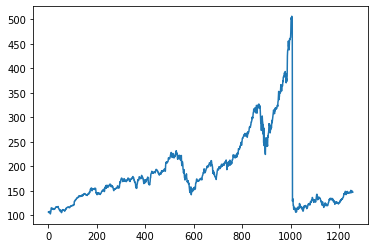

In [87]:
import matplotlib.pyplot as plt
plt.plot(dataset)

### LSTM are sensitive to the scale of the data. SP we apply MinMax scaler

In [88]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [89]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(np.array(dataset).reshape(-1,1))

In [90]:
dataset.shape

(1258, 1)

In [91]:
dataset

array([[0.00915724],
       [0.0071223 ],
       [0.00737046],
       ...,
       [0.11537125],
       [0.11224439],
       [0.11020945]])

Before the preprocessing the data</br>
Let's do train test split </br>
Whenever we are dealing with time series data we split data in different way as explained below : </br>
we should try to divide the data based on the date because as we know in stock market today's price is dependent on the previous day.

In [92]:
# splitting the dataset into train and test split
training_size = int(len(dataset)*0.65)
test_size = len(dataset) - training_size
train_data, test_data = dataset[0:training_size,:],dataset[training_size:len(dataset),:1]

Now the data we have like day1, day2, day3, day4 and so on</br>
Now we be consider a timestep like suppose if we want to compute the next day output then how many previous day we have to consider</br>
suppose timesteps = 3 then we have 3 features f1,f2,f3</br>
what we are doing in this data preprocessing is just converting the data into dependent and independent features based on the timesteps</br>
which means in order to calculate output or in order to predict the output we need to previous features equal to the value of timesteps

Dataset -  </br>
120 , 130, 125, 140, 134, 150, 160, 190, 154 </br>
Train - 120 , 130, 125, 140, 134, 150</br>
Test - 160, 190, 154</br>
timesteps = 3 </br>
<pre class = "tab1"> X_train             y_train</pre>
<pre class = "tab1">f1  f2  f3              o/p</pre>
<pre class = "tab1">120 130 125             140</pre>
<pre class = "tab1">130 125 140             134</pre>
Similarly for test data

In [93]:
# convert an array of vlaues into a dataset matrix

def create_dataset(dataset_get, time_step=1):
    dataX,dataY = [],[]
    for i in range(len(dataset_get)-time_step-1):
        a = dataset_get[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset_get[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [94]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [95]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [96]:
print(X_test.shape), print(y_test.shape)

(340, 100)
(340,)


(None, None)

In [97]:
# reshape input to be [sample,timesteps, features] which is require for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [98]:
# creating the Stack LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [99]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape = (100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',)

In [100]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 24s 771ms/step - loss: 0.0176 - val_loss: 0.0349
Epoch 2/100
12/12 [==============================] - 6s 551ms/step - loss: 0.0029 - val_loss: 0.0319
Epoch 3/100
12/12 [==============================] - 7s 636ms/step - loss: 0.0020 - val_loss: 0.0278
Epoch 4/100
12/12 [==============================] - 6s 503ms/step - loss: 0.0011 - val_loss: 0.0234
Epoch 5/100
12/12 [==============================] - 6s 485ms/step - loss: 7.0547e-04 - val_loss: 0.0302
Epoch 6/100
12/12 [==============================] - 6s 528ms/step - loss: 5.8211e-04 - val_loss: 0.0266
Epoch 7/100
12/12 [==============================] - 6s 517ms/step - loss: 5.0822e-04 - val_loss: 0.0257
Epoch 8/100
12/12 [==============================] - 6s 540ms/step - loss: 5.0648e-04 - val_loss: 0.0248
Epoch 9/100
12/12 [==============================] - 6s 476ms/step - loss: 4.8536e-04 - val_loss: 0.0246
Epoch 10/100
12/12 [==============================] - 6s 464ms/step - 

In [102]:
#  Let's do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [103]:
# Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [104]:
# calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

182.1539313834554

In [105]:
# Test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

217.8324083647205

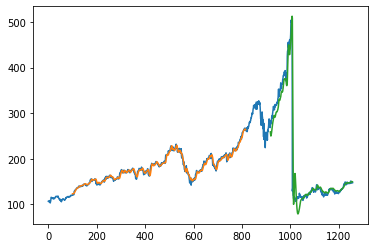

In [106]:
# Plotting 
# Shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
# shift test prediciton for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1,:] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Forecasting next 30 days

Suppose in our test data the last date is 22nd May </br>
now to calculate the output of 23rd May - we have to take the previous 100 days data then only we are able to predict 23rd May data by giving it to the LSTM model.

In [107]:
len(test_data)

441

In [108]:
x_input = test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [109]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [110]:
temp_input

[0.06147012110383171,
 0.06757494540401038,
 0.0741140559857058,
 0.06975878499106619,
 0.07767520349414342,
 0.07171927734762762,
 0.07784891800675009,
 0.07700516180266037,
 0.07869267421083981,
 0.07439944411355975,
 0.07536728211236854,
 0.07149593011713323,
 0.07740222354576137,
 0.07839487790351402,
 0.0775759380583681,
 0.07556581298391907,
 0.07531764939448088,
 0.07030474488783012,
 0.0729849116537622,
 0.06134603930911259,
 0.061966448282707975,
 0.06603633114949381,
 0.06720270001985312,
 0.05886440341473104,
 0.056531665674012355,
 0.048739328965654194,
 0.05419892793329367,
 0.06035338495136,
 0.05742505459598973,
 0.05390113162596788,
 0.05350406988286682,
 0.06000595592614655,
 0.055340480444709184,
 0.059484812388326425,
 0.0589884852094501,
 0.05886440341473104,
 0.054968235060551984,
 0.053305539011316294,
 0.05248659916617038,
 0.054422275163788,
 0.05065018860432802,
 0.056482032956124695,
 0.05650684931506855,
 0.058591423466349046,
 0.05955926146515789,
 0.0570279

In [120]:
# Demonstrate prediction for next 100 days
from numpy import array

lst_output = []
n_steps=100
i=0
while(i<100):
    if(len(temp_input)>100):
        # print(temp_input)
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1,n_steps,1))
        # print(x_input)
        yhat = model.predict(x_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input,verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

0 day input [0.05350407 0.06000596 0.05534048 0.05948481 0.05898849 0.0588644
 0.05496824 0.05330554 0.0524866  0.05442228 0.05065019 0.05648203
 0.05650685 0.05859142 0.05955926 0.05702799 0.06010522 0.06787274
 0.06578817 0.0670538  0.07112368 0.06782311 0.07238932 0.07655847
 0.07586361 0.07514393 0.07439944 0.07854378 0.08239031 0.08395374
 0.08472305 0.09139865 0.09651082 0.10283899 0.09953842 0.10417907
 0.10266528 0.10549434 0.11420488 0.11254219 0.10735557 0.09757792
 0.10675998 0.10489875 0.10837304 0.11274072 0.11380782 0.10829859
 0.10385646 0.10549434 0.1060403  0.10519655 0.10976276 0.10874528
 0.10901826 0.10673516 0.10661108 0.10539508 0.1060403  0.11355966
 0.1140808  0.11909371 0.11678579 0.10728112 0.10812488 0.11182251
 0.1155946  0.11537125 0.11224439 0.11020945 0.11523694 0.11535676
 0.1157807  0.11643133 0.11720746 0.11803198 0.11885825 0.119662
 0.12043209 0.12116416 0.12185728 0.12251247 0.12313224 0.12372019
 0.12428072 0.12481871 0.12533915 0.12584683 0.126346

In [125]:
day_new = np.arange(1,101)
day_pred = np.arange(101,201)

In [126]:
import matplotlib.pyplot as plt

In [127]:
len(dataset)

1258

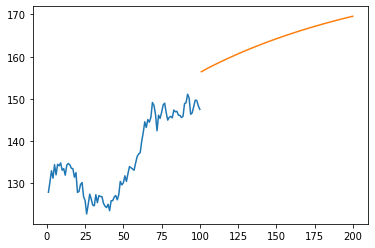

In [128]:
plt.plot(day_new,scaler.inverse_transform(dataset[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

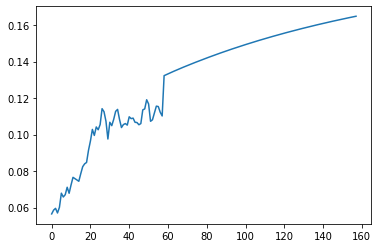

In [129]:
df3 = dataset.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [130]:
df3 = scaler.inverse_transform(df3).tolist()

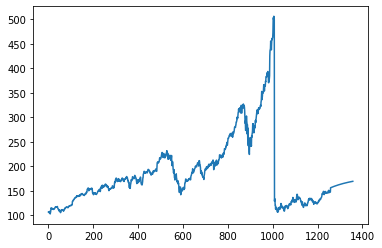

In [131]:
plt.plot(df3)